# 6. Defending against the Gradient Attack, using Defensive Distillation

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.1 (11/03/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Pillow (tested on v9.0.0)
- Torch (tested on v1.10.1)
- Torchvision (tested on v0.11.2)

### Imports

In [1]:
# Future
from __future__ import print_function
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Torchvision
from torchvision import datasets, transforms

In [2]:
# NOTE: This is a fix to work around the "User-agent" issue 
# when downloading the MNIST dataset
from six.moves import urllib
opener_req = urllib.request.build_opener()
opener_req.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener_req)

### CUDA Setup

In [3]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: False


### Dataset and Dataloader

In [4]:
# Transform definition
# (Basic: only convert image to torch tensor)
tf = transforms.Compose([transforms.ToTensor()])

In [5]:
# MNIST dataset and dataloader
# (For testing only, we will use a pre-trained model)
ds = datasets.MNIST('./data', train = False, download = True, transform = tf)
test_loader = torch.utils.data.DataLoader(ds, batch_size = 1, shuffle = True)

### Loading a pre-trained model

In [6]:
# Model definition
class Net(nn.Module):
    """
    This is a basic Neural Net for MNIST
    - Two convolutions, into ReLU activations and dropouts after ReLU,
    - Flattening,
    - Fully connected, into ReLU activation and dropout after ReLU,
    - Fully connected, into Log-Softmax.
    """
    
    def __init__(self):
        super(Net, self).__init__()
        # Conv. 1
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
        # Conv. 2
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        # Dropout for Conv. layers
        self.conv2_drop = nn.Dropout2d()
        # FC 1
        self.fc1 = nn.Linear(320, 50)
        # FC 2
        self.fc2 = nn.Linear(50, 10)
        # Temperature (set to 1 by default)
        self.T = 1

    def forward(self, x):
        # Conv. 1 + ReLU + Dropout
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Conv. 2 + ReLU + Dropout
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten
        x = x.view(-1, 320)
        # FC 1 + ReLU + Droupout 
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        # FC 2 + Log-Softmax
        x = self.fc2(x)
        return F.log_softmax(x/self.T, dim = 1)

In [7]:
# Load the pretrained model
model = Net()
pretrained_model = "./mnist_model.data"
model.load_state_dict(torch.load(pretrained_model, map_location = 'cpu'))
model.to(device)

<All keys matched successfully>

In [8]:
# Set the model in evaluation mode
# (Important, because we have dropout layers!)
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### Untargeted Gradient Method (UGM) attack function

In [9]:
def ugm_attack(image, epsilon, data_grad):
    
    # Create the attack image by adjusting each pixel of the input image
    eps_image = image + epsilon*data_grad
    
    # Clipping eps_image to maintain pixel values into the [0, 1] range
    eps_image = torch.clamp(eps_image, 0, 1)
    
    # Return
    return eps_image

### Testing FGSM attacks on our model

In [10]:
def test(model, device, test_loader, epsilon):
    
    # Counter for correct values (used for accuracy)
    correct_counter = 0
    
    # List of successful adversarial samples
    adv_examples_list = []

    # Loop over all examples in test set
    for image, label in test_loader:

        # Send the data and label to the device
        image, label = image.to(device), label.to(device)

        # Set requires_grad attribute of tensor to force torch to
        # keep track of the gradients of the image
        # (Needed for the fgsm_attack() function!)
        image.requires_grad = True

        # Pass the image through the model
        output = model(image)
        # Get the index of the max log-probability
        init_pred = output.max(1, keepdim = True)[1] 

        # If the initial prediction is wrong, do not bother attacking, skip current image
        if init_pred.item() != label.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, label)

        # Zero all existing gradients
        model.zero_grad()

        # Backpropagate
        loss.backward()

        # Collect gradients of image
        data_grad = image.grad.data

        # Call FGSM Attack
        eps_image = ugm_attack(image, epsilon, data_grad)

        # Re-classify the epsilon image
        output2 = model(eps_image)
        # Get the index of the max log-probability
        eps_pred = output2.max(1, keepdim = True)[1]

        # Check for successful attack
        # (Successful meaning eps_pred label different from init_pred)
        if eps_pred.item() == label.item():
            correct_counter += 1
            # Special case for saving 0 epsilon examples
            # (Maximal number of saved samples is set to 5)
            if (epsilon == 0) and (len(adv_examples_list) < 5):
                adv_ex = eps_image.squeeze().detach().cpu().numpy()
                adv_examples_list.append((init_pred.item(), eps_pred.item(), adv_ex))
        else:
            # Save some adv examples for visualization later
            # (Maximal number of saved samples is set to 5)
            if len(adv_examples_list) < 5:
                adv_ex = eps_image.squeeze().detach().cpu().numpy()
                adv_examples_list.append((init_pred.item(), eps_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon value
    final_acc = correct_counter/float(len(test_loader))
    
    # Display for progress
    print("Epsilon: {} - Test Accuracy = {}/{} = {}".format(epsilon, \
                                                            correct_counter, \
                                                            len(test_loader), \
                                                            final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples_list

In [11]:
epsilons = [0, .2, .4, .8, 1, 2, 5]
accuracies = []
examples = []

# Run test() function for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0 - Test Accuracy = 9810/10000 = 0.981
Epsilon: 0.2 - Test Accuracy = 9702/10000 = 0.9702
Epsilon: 0.4 - Test Accuracy = 9622/10000 = 0.9622
Epsilon: 0.8 - Test Accuracy = 9404/10000 = 0.9404
Epsilon: 1 - Test Accuracy = 9285/10000 = 0.9285
Epsilon: 2 - Test Accuracy = 8782/10000 = 0.8782
Epsilon: 5 - Test Accuracy = 7429/10000 = 0.7429


### Visualization (accuracies vs. epsilon values and adversarial samples)

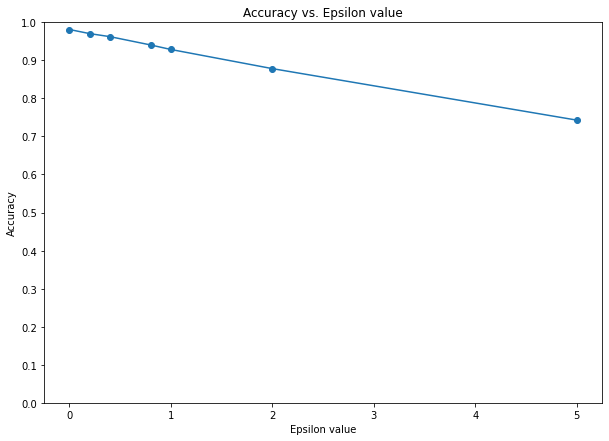

In [12]:
# Initialize figure
plt.figure(figsize = (10, 7))

# Display accuracy vs. Epsilon values plot
plt.plot(epsilons, accuracies, "o-")

# Adjust x-axis and y-axis labels and ticks
plt.yticks(np.arange(0, 1.1, step = 0.1))
#plt.xticks(np.arange(0, .35, step = 0.05))
plt.title("Accuracy vs. Epsilon value")
plt.xlabel("Epsilon value")
plt.ylabel("Accuracy")

# Display
plt.show()

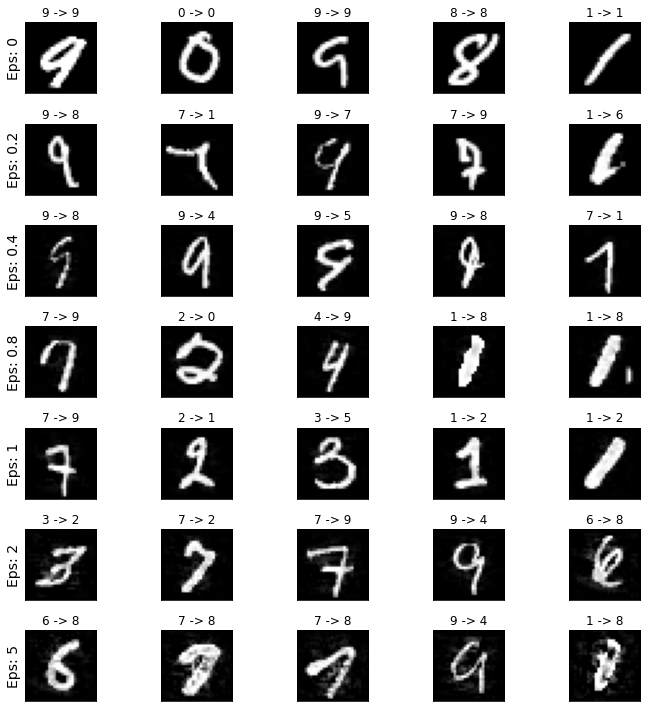

In [13]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0

# Initialize figure
plt.figure(figsize = (10, 10))

# Browse through epsilon values and adversarial examples
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        
        # Remove x-axis and y-axis ticks from plot
        plt.xticks([], [])
        plt.yticks([], [])
        
        # Labels for y axis
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize = 14)
            
        # Labels for each image subplot
        orig, adv, ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        
        # Display image
        plt.imshow(ex, cmap = "gray")
        
# Display full plot
plt.tight_layout()
plt.show()

### Creating a second model, retraining with defense

In [14]:
# Load the pretrained model
model2 = Net()
pretrained_model = "./mnist_model.data"
model2.load_state_dict(torch.load(pretrained_model, map_location = 'cpu'))
model2.to(device)

<All keys matched successfully>

In [15]:
# MNIST dataset and dataloader
# (For testing only, we will use a pre-trained model)
ds2 = datasets.MNIST('./data', train = True, download = True, transform = tf)
train_loader = torch.utils.data.DataLoader(ds2, batch_size = 64, shuffle = True)

In [16]:
print(len(train_loader))

938


In [17]:
# Define a loss function and an optimizer for training
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr = 0.001, momentum = 0.9)

In [18]:
# Setting temperature to 100 for training
model2.T = 100

In [19]:
def retrain(model, train_loader, optimizer, criterion, n_iter = 10):
    
    # This will make prints happen every 50 mini-batches
    mod_val = 50
    
    # Train over n_iter epochs
    for epoch in range(n_iter):
        
        # Keep track of the running losses over batches
        running_loss_normal = 0.0
        
        for i, data in enumerate(train_loader):

            # Retrieve input images and labels
            inputs, labels = data
            inputs.requires_grad = True

            # Zeroing gradients
            optimizer.zero_grad()

            # Forward, Loss, Backprop, Optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Keep track of running loss (normal samples)
            running_loss_normal += loss.item()
            
            # Display for progress
            if i != 1:
                str1 = '[Epoch %d, Batch %5d] Loss: %.3f' %(epoch + 1, i + 1, running_loss_normal/(i+1))
                print(str1)

In [20]:
retrain(model2, train_loader, optimizer, criterion, n_iter = 50)

[Epoch 1, Batch    51] Loss: 2.258
[Epoch 1, Batch   101] Loss: 2.256
[Epoch 1, Batch   151] Loss: 2.254
[Epoch 1, Batch   201] Loss: 2.252
[Epoch 1, Batch   251] Loss: 2.250
[Epoch 1, Batch   301] Loss: 2.248
[Epoch 1, Batch   351] Loss: 2.245
[Epoch 1, Batch   401] Loss: 2.243
[Epoch 1, Batch   451] Loss: 2.241
[Epoch 1, Batch   501] Loss: 2.238
[Epoch 1, Batch   551] Loss: 2.236
[Epoch 1, Batch   601] Loss: 2.233
[Epoch 1, Batch   651] Loss: 2.230
[Epoch 1, Batch   701] Loss: 2.227
[Epoch 1, Batch   751] Loss: 2.223
[Epoch 1, Batch   801] Loss: 2.220
[Epoch 1, Batch   851] Loss: 2.216
[Epoch 1, Batch   901] Loss: 2.212
[Epoch 2, Batch    51] Loss: 2.122
[Epoch 2, Batch   101] Loss: 2.114
[Epoch 2, Batch   151] Loss: 2.106
[Epoch 2, Batch   201] Loss: 2.098
[Epoch 2, Batch   251] Loss: 2.089
[Epoch 2, Batch   301] Loss: 2.080
[Epoch 2, Batch   351] Loss: 2.071
[Epoch 2, Batch   401] Loss: 2.061
[Epoch 2, Batch   451] Loss: 2.051
[Epoch 2, Batch   501] Loss: 2.040
[Epoch 2, Batch   55

[Epoch 13, Batch   901] Loss: 0.351
[Epoch 14, Batch    51] Loss: 0.346
[Epoch 14, Batch   101] Loss: 0.353
[Epoch 14, Batch   151] Loss: 0.348
[Epoch 14, Batch   201] Loss: 0.343
[Epoch 14, Batch   251] Loss: 0.341
[Epoch 14, Batch   301] Loss: 0.341
[Epoch 14, Batch   351] Loss: 0.343
[Epoch 14, Batch   401] Loss: 0.341
[Epoch 14, Batch   451] Loss: 0.341
[Epoch 14, Batch   501] Loss: 0.342
[Epoch 14, Batch   551] Loss: 0.340
[Epoch 14, Batch   601] Loss: 0.338
[Epoch 14, Batch   651] Loss: 0.338
[Epoch 14, Batch   701] Loss: 0.338
[Epoch 14, Batch   751] Loss: 0.338
[Epoch 14, Batch   801] Loss: 0.339
[Epoch 14, Batch   851] Loss: 0.339
[Epoch 14, Batch   901] Loss: 0.339
[Epoch 15, Batch    51] Loss: 0.321
[Epoch 15, Batch   101] Loss: 0.326
[Epoch 15, Batch   151] Loss: 0.334
[Epoch 15, Batch   201] Loss: 0.331
[Epoch 15, Batch   251] Loss: 0.331
[Epoch 15, Batch   301] Loss: 0.329
[Epoch 15, Batch   351] Loss: 0.326
[Epoch 15, Batch   401] Loss: 0.327
[Epoch 15, Batch   451] Loss

[Epoch 26, Batch   601] Loss: 0.267
[Epoch 26, Batch   651] Loss: 0.267
[Epoch 26, Batch   701] Loss: 0.268
[Epoch 26, Batch   751] Loss: 0.267
[Epoch 26, Batch   801] Loss: 0.268
[Epoch 26, Batch   851] Loss: 0.268
[Epoch 26, Batch   901] Loss: 0.267
[Epoch 27, Batch    51] Loss: 0.248
[Epoch 27, Batch   101] Loss: 0.249
[Epoch 27, Batch   151] Loss: 0.249
[Epoch 27, Batch   201] Loss: 0.251
[Epoch 27, Batch   251] Loss: 0.253
[Epoch 27, Batch   301] Loss: 0.254
[Epoch 27, Batch   351] Loss: 0.254
[Epoch 27, Batch   401] Loss: 0.255
[Epoch 27, Batch   451] Loss: 0.253
[Epoch 27, Batch   501] Loss: 0.253
[Epoch 27, Batch   551] Loss: 0.256
[Epoch 27, Batch   601] Loss: 0.256
[Epoch 27, Batch   651] Loss: 0.255
[Epoch 27, Batch   701] Loss: 0.256
[Epoch 27, Batch   751] Loss: 0.257
[Epoch 27, Batch   801] Loss: 0.257
[Epoch 27, Batch   851] Loss: 0.258
[Epoch 27, Batch   901] Loss: 0.257
[Epoch 28, Batch    51] Loss: 0.248
[Epoch 28, Batch   101] Loss: 0.251
[Epoch 28, Batch   151] Loss

[Epoch 39, Batch   301] Loss: 0.230
[Epoch 39, Batch   351] Loss: 0.229
[Epoch 39, Batch   401] Loss: 0.229
[Epoch 39, Batch   451] Loss: 0.230
[Epoch 39, Batch   501] Loss: 0.230
[Epoch 39, Batch   551] Loss: 0.230
[Epoch 39, Batch   601] Loss: 0.230
[Epoch 39, Batch   651] Loss: 0.230
[Epoch 39, Batch   701] Loss: 0.231
[Epoch 39, Batch   751] Loss: 0.232
[Epoch 39, Batch   801] Loss: 0.232
[Epoch 39, Batch   851] Loss: 0.230
[Epoch 39, Batch   901] Loss: 0.230
[Epoch 40, Batch    51] Loss: 0.240
[Epoch 40, Batch   101] Loss: 0.238
[Epoch 40, Batch   151] Loss: 0.229
[Epoch 40, Batch   201] Loss: 0.237
[Epoch 40, Batch   251] Loss: 0.231
[Epoch 40, Batch   301] Loss: 0.232
[Epoch 40, Batch   351] Loss: 0.232
[Epoch 40, Batch   401] Loss: 0.232
[Epoch 40, Batch   451] Loss: 0.230
[Epoch 40, Batch   501] Loss: 0.231
[Epoch 40, Batch   551] Loss: 0.230
[Epoch 40, Batch   601] Loss: 0.231
[Epoch 40, Batch   651] Loss: 0.232
[Epoch 40, Batch   701] Loss: 0.232
[Epoch 40, Batch   751] Loss

In [21]:
# After retraining, set the model in evaluation mode
# (Important, because we have dropout layers!)
model2.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [22]:
# Setting temperature back to 1 for eval
model2.T = 1

### Testing FGSM attacks on our defended model

In [23]:
epsilons = [0, .2, .4, .8, 1, 2, 5]
accuracies2 = []
examples2 = []

# Run test() function for each epsilon
for eps in epsilons:
    acc, ex = test(model2, device, test_loader, eps)
    accuracies2.append(acc)
    examples2.append(ex)

Epsilon: 0 - Test Accuracy = 9737/10000 = 0.9737
Epsilon: 0.2 - Test Accuracy = 9727/10000 = 0.9727
Epsilon: 0.4 - Test Accuracy = 9726/10000 = 0.9726
Epsilon: 0.8 - Test Accuracy = 9724/10000 = 0.9724
Epsilon: 1 - Test Accuracy = 9724/10000 = 0.9724
Epsilon: 2 - Test Accuracy = 9723/10000 = 0.9723
Epsilon: 5 - Test Accuracy = 9721/10000 = 0.9721


### Visualization part 2 (accuracies vs. epsilon values for both models)

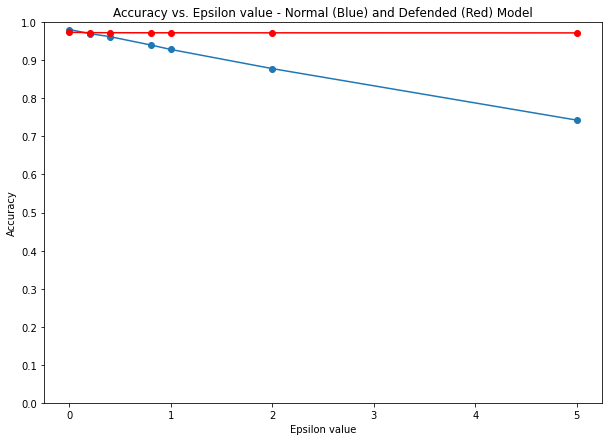

In [24]:
# Initialize figure
plt.figure(figsize = (10, 7))

# Display accuracy vs. Epsilon values plot
plt.plot(epsilons, accuracies, "o-")
plt.plot(epsilons, accuracies2, "o-", color = "red")

# Adjust x-axis and y-axis labels and ticks
plt.yticks(np.arange(0, 1.1, step = 0.1))
#plt.xticks(np.arange(0, .35, step = 0.05))
plt.title("Accuracy vs. Epsilon value - Normal (Blue) and Defended (Red) Model")
plt.xlabel("Epsilon value")
plt.ylabel("Accuracy")

# Display
plt.show()

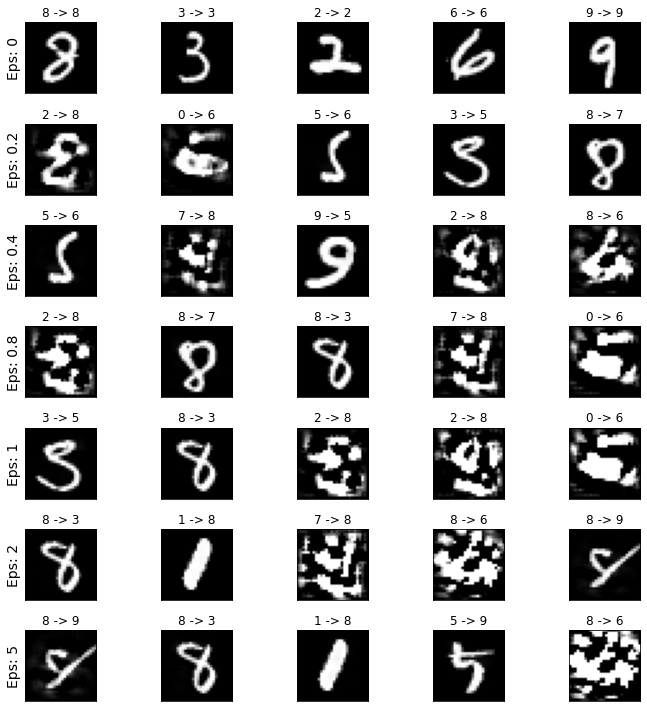

In [25]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0

# Initialize figure
plt.figure(figsize = (10, 10))

# Browse through epsilon values and adversarial examples
for i in range(len(epsilons)):
    for j in range(len(examples2[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples2[0]), cnt)
        
        # Remove x-axis and y-axis ticks from plot
        plt.xticks([], [])
        plt.yticks([], [])
        
        # Labels for y axis
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize = 14)
            
        # Labels for each image subplot
        orig, adv, ex = examples2[i][j]
        plt.title("{} -> {}".format(orig, adv))
        
        # Display image
        plt.imshow(ex, cmap = "gray")
        
# Display full plot
plt.tight_layout()
plt.show()